In [46]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from rbflayer import RBFLayer, InitCentersRandom
from keras.models import load_model
from err import error_count, calc_diff
from visual import plot
import os

In [25]:
############ Data Preprocessing ############
# Importing the dataset
ds = pd.read_csv(os.path.join(os.getcwd(),'dsProject/YESBANK.NS.csv'))
print(ds.head())

X = ds.drop(['Date', 'Close'], axis=1)
y = ds['Close'].to_numpy()[:, None]

# Feature Scaling
scalerX  = MinMaxScaler(feature_range=(0, 1))
scalerY  = MinMaxScaler(feature_range=(0, 1))

X = scalerX.fit_transform(X)
y = scalerY.fit_transform(y)

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Sizes of dataset, train_ds, test_ds
dataset_sz = X.shape[0]
train_sz = X_train.shape[0]
test_sz = X_test.shape[0]

X_train = np.reshape(X_train, (train_sz, 5))
y_train = np.reshape(y_train, (train_sz, 1))

         Date       Open       High        Low      Close  Adj Close  \
0  2020-12-21  18.950001  19.000000  18.000000  18.000000  18.000000   
1  2020-12-22  17.400000  17.600000  17.100000  17.299999  17.299999   
2  2020-12-23  17.500000  17.850000  17.049999  17.600000  17.600000   
3  2020-12-24  17.900000  18.000000  17.299999  17.549999  17.549999   
4  2020-12-28  17.799999  18.200001  17.549999  17.799999  17.799999   

      Volume  
0  168955038  
1  284913909  
2  216066991  
3  124638448  
4  149082382  


In [93]:
############ Building the RBF ############
# Initialising the RBF
regressor = Sequential()

# Adding the input layer and the first layer and Drop out Regularization
regressor.add(RBFLayer(50, initializer=InitCentersRandom(X_train),betas=2.0, input_shape=(5,)))
regressor.add(Dropout(.2))

# Adding the output layer
regressor.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [99]:
# Compiling the RBF
regressor.compile(optimizer = optimizers.adam_v2.Adam(learning_rate=0.001), loss = 'mean_squared_error', metrics=['mape', 'mse', 'mae'])

# Fitting the RBF to the Training set
h=regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
13/13 [==============================] - 1s 3ms/step - loss: 0.0043 - mape: 444286.0938 - mse: 0.0043 - mae: 0.0383
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0039 - mape: 450362.0625 - mse: 0.0039 - mae: 0.0376
Epoch 3/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0036 - mape: 373593.1250 - mse: 0.0036 - mae: 0.0356
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0037 - mape: 293619.2188 - mse: 0.0037 - mae: 0.0377
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0035 - mape: 417906.6562 - mse: 0.0035 - mae: 0.0353
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0034 - mape: 299313.7188 - mse: 0.0034 - mae: 0.0347
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0033 - mape: 329346.5938 - mse: 0.0033 - mae: 0.0354
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0031 - mape: 306456.5938 - ms

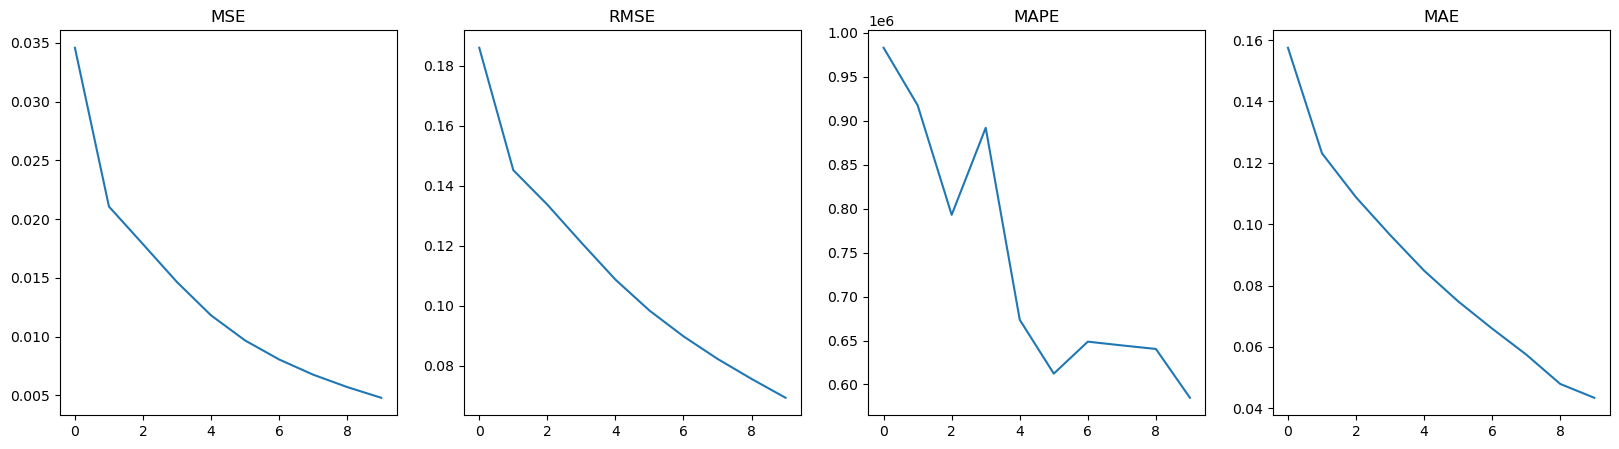

In [96]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].plot(h.history['loss'])
axs[0].set_title('MSE')
axs[1].plot(np.sqrt(h.history['loss']))
axs[1].set_title('RMSE')
axs[2].plot(h.history['mape'])
axs[2].set_title('MAPE')
axs[3].plot(h.history['mae'])
axs[3].set_title('MAE')
plt.show()

In [103]:
############ Save & load Trained Model ############
# Save Trained Model
regressor.save('RBF Model')

INFO:tensorflow:Assets written to: RBF Model/assets


In [59]:
# load Trained Model
regressor = load_model('RBF Model', custom_objects={'RBFLayer':RBFLayer})

16/16 [==============================] - 0s 870us/step


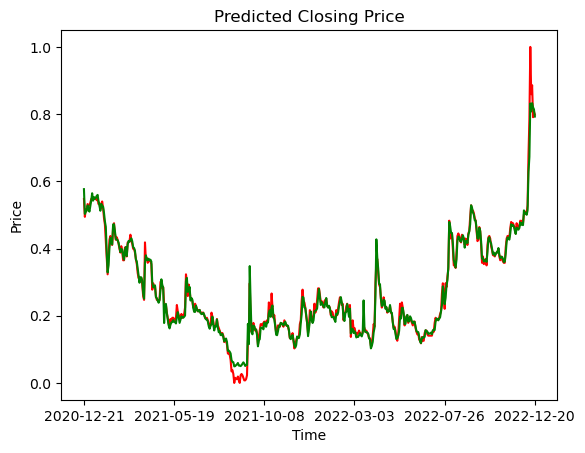

In [104]:
pred = regressor.predict(X)[:, 0]
plt.plot(y, color=(1, 0, 0))
plt.plot(pred, color=(0, 0.5, 0))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted Closing Price')
plt.xticks(range(0, len(pred), len(X)//5), ds['Date'][0:len(X):len(X)//5])
plt.show()
np.save('RBF', scalerY.inverse_transform(pred[:, None])[:, 0])

In [85]:
ds['Close'][:len(X_train)].shape

(396,)